In [6]:
from fastai.vision.all import *
from fastai.medical.imaging import *

In [7]:
pd.options.display.max_columns = 100

In [8]:
from lungmask import utils as lungmask_utils
from lungmask import mask as lungmask_mask
import SimpleITK as sitk

In [9]:
device = default_device()

In [12]:
# lungmask model - offline
model = lungmask_mask.get_model('unet', 'R231')
model.to(device)
model.eval();

Downloading: "https://github.com/JoHof/lungmask/releases/download/v0.0/unet_r231-d5d2fc3d.pth" to /root/.cache/torch/hub/checkpoints/unet_r231-d5d2fc3d.pth


In [13]:
study_dirname = "dcm_demo/"

In [16]:
from tqdm import tqdm
def lungmask_apply(image, model=None, force_cpu=False, batch_size=20, volume_postprocessing=True, noHU=False):

    tvolslices, xnew_box = lungmask_utils.preprocess(image, resolution=[256, 256])
    tvolslices[tvolslices > 600] = 600
    tvolslices = np.divide((tvolslices + 1024), 1624)

    torch_ds_val = lungmask_utils.LungLabelsDS_inf(tvolslices)
    dataloader_val = torch.utils.data.DataLoader(torch_ds_val, 
                                                 batch_size=batch_size,
                                                 shuffle=False, 
                                                 num_workers=defaults.cpus,
                                                 pin_memory=False)

    timage_res = np.empty((np.append(0, tvolslices[0].shape)), dtype=np.uint8)

    with torch.no_grad():
        for X in tqdm(dataloader_val):
            X = X.float().to(device)
            prediction = model(X)
            pls = torch.max(prediction, 1)[1].detach().cpu().numpy().astype(np.uint8)
            timage_res = np.vstack((timage_res, pls))

    # postprocessing includes removal of small connected components, hole filling and mapping of small components to
    # neighbors

    outmask = timage_res
    outmask = np.asarray([lungmask_utils.reshape_mask(outmask[i], xnew_box[i], image.shape[1:]) 
                          for i in range(outmask.shape[0])], dtype=np.uint8)
        
    return outmask.astype(np.uint8)

In [17]:
dcmfiles = get_dicom_files(study_dirname)
x = torch.stack([o.dcmread().scaled_px for o in dcmfiles])
study_masks = lungmask_apply(x, model)

100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


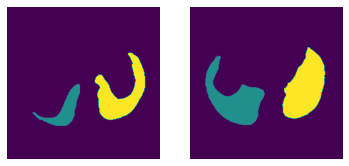

In [18]:
show_images(study_masks)

In [19]:
# RGB windows
lung_window = (1500, -600)
pe_window = (700, 100)
mediastinal_window = (400, 40)
windows = (lung_window, pe_window, mediastinal_window)

In [20]:
dcmfiles = get_dicom_files(study_dirname)
dcm_metadf = (pd.DataFrame.from_dicoms(dcmfiles, window=pe_window)
                          .sort_values(['StudyInstanceUID', 'ImagePositionPatient2'])
                          .reset_index(drop=True))

In [21]:
dcm_metadf

,SpecificCharacterSet,ImageType,SOPClassUID,SOPInstanceUID,Modality,,SliceThickness,KVP,GantryDetectorTilt,TableHeight,RotationDirection,XRayTubeCurrent,Exposure,ConvolutionKernel,PatientPosition,StudyInstanceUID,SeriesInstanceUID,SeriesNumber,InstanceNumber,ImagePositionPatient,ImageOrientationPatient,FrameOfReferenceUID,SamplesPerPixel,PhotometricInterpretation,Rows,Columns,PixelSpacing,BitsAllocated,BitsStored,HighBit,PixelRepresentation,WindowCenter,WindowWidth,RescaleIntercept,RescaleSlope,fname,MultiImageType,ImageType1,ImageType2,MultiImagePositionPatient,ImagePositionPatient1,ImagePositionPatient2,MultiImageOrientationPatient,ImageOrientationPatient1,ImageOrientationPatient2,ImageOrientationPatient3,ImageOrientationPatient4,ImageOrientationPatient5,MultiPixelSpacing,PixelSpacing1,img_min,img_max,img_mean,img_std,img_pct_window
0,ISO_IR 100,ORIGINAL,80e30f500244,00ac73cfc372,CT,GEIIS,1.25,140.0,0.0,203.0,CW,663,7,STANDARD,FFS,0003b3d648eb,d2b2960c2bbf,3,40,-199.2,1.0,d965c49c4a74,1,MONOCHROME2,512,512,0.871094,16,16,15,1,40.0,400.0,-1024.0,1.0,dcm_demo/00ac73cfc372.dcm,1,PRIMARY,AXIAL,1,-223.0,-271.75,1,0.0,0.0,0.0,1.0,0.0,1,0.871094,-2000,1939,223.787903,1197.828369,0.600773
1,ISO_IR 100,ORIGINAL,80e30f500244,03d7693b0405,CT,GEIIS,1.25,140.0,0.0,203.0,CW,663,7,STANDARD,FFS,0003b3d648eb,d2b2960c2bbf,3,63,-199.2,1.0,d965c49c4a74,1,MONOCHROME2,512,512,0.871094,16,16,15,1,40.0,400.0,-1024.0,1.0,dcm_demo/03d7693b0405.dcm,1,PRIMARY,AXIAL,1,-223.0,-243.00,1,0.0,0.0,0.0,1.0,0.0,1,0.871094,-2000,2040,168.193314,1180.321879,0.534206


In [22]:
study_fnames = dcm_metadf['fname'].values
dcm_ds = [Path(o).dcmread() for o in study_fnames]

In [23]:
def read_dcm_img(dcm, windows=windows):
    "Read single slice in RGB"
    return torch.stack([dcm.windowed(*w) for w in windows])

In [24]:
imgs = torch.stack([read_dcm_img(o) for o in dcm_ds]); imgs.shape

torch.Size([2, 3, 512, 512])

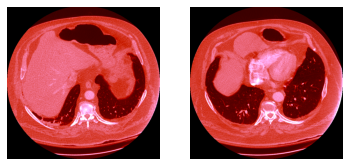

In [25]:
show_images(imgs)

In [26]:
def px_msk_bounds(mask:Tensor, pad_ratio=0.05):
    "N dimensional mask with last 2 dimensions (h,w)"
    idxs = mask.nonzero()
    h,w = mask.size(-2),mask.size(-1)
    ymin,ymax,xmin,xmax = (idxs[:,-2].min(), idxs[:,-2].max(), 
                           idxs[:,-1].min(), idxs[:,-1].max())
    ph, pw = (h*pad_ratio,w*pad_ratio)
    ymin,ymax,xmin,xmax = (int(ymin - ph//2), int(ymax + ph//2),
                           int(xmin - pw//2), int(xmax + pw//2))
    ymin,ymax,xmin,xmax = max(0,ymin),min(h,ymax),max(0,xmin),min(w,xmax)
    return (ymin,ymax,xmin,xmax)

In [27]:
mask = tensor(study_masks)
ymin,ymax,xmin,xmax = px_msk_bounds(mask)
cropped = imgs[:,:,ymin:ymax,xmin:xmax]

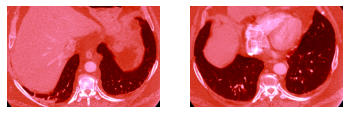

In [28]:
show_images(cropped)

In [29]:
cropped.shape

torch.Size([2, 3, 286, 433])

In [30]:
def save_img(t:Tensor, fn):
    "Save single slice in RGB"
    t = (t*255).byte()
    im = Image.fromarray(t.permute(1,2,0).numpy(), mode=['RGB','CMYK'][t.shape[0]==4])
    im.save(fn, quality=90)

In [31]:
outdir = Path("dcm_demo_output")
if not outdir.exists(): outdir.mkdir()

In [32]:
for fn, t in zip(study_fnames, cropped):
    save_img(t, outdir/f"{Path(fn).stem}.jpg")

### Save sample studies

In [33]:
datapath = Path("/home/code-base/scratch_space/rsna_data/")

In [34]:
# sample_studies = np.random.choice((datapath/'train').ls(), 100, replace=False)
# sample_studies = np.random.permutation(sample_studies)
# valid_pids = [o.stem for o in sample_studies[:10]]
# train_pids = [o.stem for o in sample_studies[10:]]
# sample_pids_dir = (datapath/'sample_pids')
# if not sample_pids_dir.exists(): sample_pids_dir.mkdir()
# pd.to_pickle(valid_pids, sample_pids_dir/'valid_pids.pkl')
# pd.to_pickle(train_pids, sample_pids_dir/'train_pids.pkl')
# assert set(train_pids).intersection(set(valid_pids)) == set()

In [35]:
# !rm -r {datapath/'cropped'}
# !rm -r {datapath/'metadata'}

In [36]:
cropped_dir = datapath/'cropped'
if not cropped_dir.exists(): cropped_dir.mkdir()

In [37]:
metadata_dir = datapath/'metadata'
if not metadata_dir.exists(): metadata_dir.mkdir()

In [38]:
cropped_dir.ls(), metadata_dir.ls()

((#0) [],
 (#200) [Path('/home/code-base/scratch_space/rsna_data/metadata/41d63a87e4c4.csv'),Path('/home/code-base/scratch_space/rsna_data/metadata/fcc03982d100.csv'),Path('/home/code-base/scratch_space/rsna_data/metadata/e50100bd0713.csv'),Path('/home/code-base/scratch_space/rsna_data/metadata/0d620a51fbf9.csv'),Path('/home/code-base/scratch_space/rsna_data/metadata/102a108e835a.csv'),Path('/home/code-base/scratch_space/rsna_data/metadata/01272322296e.csv'),Path('/home/code-base/scratch_space/rsna_data/metadata/3d8ce6b80cb5.csv'),Path('/home/code-base/scratch_space/rsna_data/metadata/af78ce88506c.csv'),Path('/home/code-base/scratch_space/rsna_data/metadata/8e5b0925b0b0.csv'),Path('/home/code-base/scratch_space/rsna_data/metadata/64918c620110.csv')...])

In [39]:
sample_pids_dir = (datapath/'sample_pids')
valid_pids = pd.read_pickle(sample_pids_dir/'valid_pids.pkl')
train_pids = pd.read_pickle(sample_pids_dir/'train_pids.pkl')

In [40]:
study_pids = train_pids + valid_pids; len(study_pids)

100

In [41]:
from fastai.medical.imaging  import _split_elem, _cast_dicom_special
@patch
def as_dict(self:DcmDataset, px_summ=True, window=dicom_windows.brain):
    "Convert the header of a dicom into a dictionary"
    pxdata = (0x7fe0,0x0010)
    vals = [self[o] for o in self.keys() if o != pxdata]
    its = [(v.keyword,v.value) for v in vals]
    res = dict(its)
    res['fname'] = self.filename
    for k,v in its: _split_elem(res,k,v)
    if not px_summ: return res
    stats = 'min','max','mean','std'
    try:
        pxs = self.pixel_array
        for f in stats: res['img_'+f] = getattr(pxs,f)()
        res['img_pct_window'] = self.pct_in_window(*window)
    except Exception as e:
#         for f in stats: res['img_'+f] = 0
#         print(res,e)
        raise e
    for k in res: res[k] = _cast_dicom_special(res[k])
    return res

In [42]:
def get_study_lungmask(study_dirname):
    dcmfiles = get_dicom_files(study_dirname)
    x = torch.stack([o.dcmread().scaled_px for o in dcmfiles])
    study_masks = lungmask_apply(x, model)
    return tensor(study_masks)

In [43]:
import skimage
def simple_bodymask(img):
    maskthreshold = -500
    oshape = img.shape
    img = ndimage.zoom(img, 128/np.asarray(img.shape), order=0)
    bodymask = img > maskthreshold
    bodymask = ndimage.binary_closing(bodymask)
    bodymask = ndimage.binary_fill_holes(bodymask, structure=np.ones((3, 3))).astype(int)
    bodymask = ndimage.binary_erosion(bodymask, iterations=2)
    bodymask = skimage.measure.label(bodymask.astype(int), connectivity=1)
    regions = skimage.measure.regionprops(bodymask.astype(int))
    if len(regions) > 0:
        max_region = np.argmax(list(map(lambda x: x.area, regions))) + 1
        bodymask = bodymask == max_region
        bodymask = ndimage.binary_dilation(bodymask, iterations=2)
    real_scaling = np.asarray(oshape)/128
    return ndimage.zoom(bodymask, real_scaling, order=0)

In [44]:
def lungmask_crop_and_resize(img, mask=None, width=192, height=192):
    bmask = simple_bodymask(img)
    # img[bmask==0] = -1024 # this line removes background outside of the lung.
    # However, it has been shown problematic with narrow circular field of views that touch the lung.
    # Possibly doing more harm than help
    reg = skimage.measure.regionprops(skimage.measure.label(bmask))
    if len(reg) > 0:
        bbox = np.asarray(reg[0].bbox)
    else:
        bbox = (0, 0, bmask.shape[0], bmask.shape[1])
    img = img[bbox[0]:bbox[2], bbox[1]:bbox[3]]
    img = ndimage.zoom(img, np.asarray([width, height]) / np.asarray(img.shape), order=1)
    if not mask is None:
        mask = mask[bbox[0]:bbox[2], bbox[1]:bbox[3]]
        mask = ndimage.zoom(mask, np.asarray([width, height]) / np.asarray(mask.shape), order=0)
        # mask = ndimage.binary_closing(mask,iterations=5)
    return img, mask, bbox

In [45]:
def lungmask_preprocess(img, label=None, resolution=[192, 192]):
    imgmtx = np.copy(img)

    imgmtx[imgmtx < -1024] = -1024
    imgmtx[imgmtx > 600] = 600
    cip_xnew = []
    cip_box = []
    cip_mask = []
    for i in range(imgmtx.shape[0]):
        (im, m, box) = lungmask_crop_and_resize(imgmtx[i, :, :], width=resolution[0], height=resolution[1])
        cip_xnew.append(im)
        cip_box.append(box)
    if label is None:
        return np.asarray(cip_xnew), cip_box
    else:
        return np.asarray(cip_xnew), cip_box, np.asarray(cip_mask)

In [56]:
def save_metadata_and_cropped_imgs(study_dirname, save_metadata=True):
    try:
        # get metadata
        dcmfiles = get_dicom_files(study_dirname)
        dcm_metadf = (pd.DataFrame.from_dicoms(dcmfiles, window=pe_window)
                                  .sort_values(['StudyInstanceUID', 'ImagePositionPatient2'])
                                  .reset_index(drop=True))
        study_fnames = dcm_metadf['fname'].values
        
        # get ordered imgs
        dcm_ds = [Path(o).dcmread() for o in study_fnames]
        imgs = torch.stack([read_dcm_img(o) for o in dcm_ds])

        # get cropped imgs
        x = torch.stack([o.scaled_px for o in dcm_ds])
        study_masks = lungmask_apply(x, model, batch_size=4)
        ymin,ymax,xmin,xmax = px_msk_bounds(tensor(study_masks))
        cropped = imgs[:,:,ymin:ymax,xmin:xmax]

        # save cropped imgs in order
        outdir = cropped_dir/study_dirname.name
        if not outdir.exists(): outdir.mkdir()
        for i, (fn, t) in enumerate(zip(study_fnames, cropped)):
            save_img(t, outdir/f"{i}_{Path(fn).stem}.jpg")

        # save metadata
        if save_metadata:
            dcm_metadf.to_csv(metadata_dir/f"{study_dirname.name}.csv")
        
    except Exception as e:
        # install GDCM offline in inference kernel
        if "GDCM" in str(e): print(f"Possible GDCM issue skipping: {study_dirname}")
        else: raise e

In [57]:
cropped_dir

Path('/home/code-base/scratch_space/rsna_data/cropped')

In [60]:
def save_studies():
    study_dirnames = [datapath/'train'/o for o in study_pids]
    for study_dirname in progress_bar(study_dirnames):
        save_metadata_and_cropped_imgs(study_dirname)

In [61]:
save_studies()

100%|██████████| 64/64 [00:06<00:00, 10.34it/s]


100%|██████████| 58/58 [00:05<00:00, 10.94it/s]


100%|██████████| 62/62 [00:05<00:00, 10.96it/s]


100%|██████████| 50/50 [00:04<00:00, 10.18it/s]


100%|██████████| 46/46 [00:04<00:00, 11.06it/s]


100%|██████████| 54/54 [00:04<00:00, 11.81it/s]


100%|██████████| 84/84 [00:06<00:00, 12.29it/s]


100%|██████████| 83/83 [00:07<00:00, 11.81it/s]


100%|██████████| 54/54 [00:05<00:00, 10.50it/s]


100%|██████████| 45/45 [00:04<00:00,  9.06it/s]


100%|██████████| 57/57 [00:05<00:00,  9.54it/s]


100%|██████████| 47/47 [00:04<00:00,  9.46it/s]


100%|██████████| 54/54 [00:04<00:00, 11.43it/s]


100%|██████████| 155/155 [00:12<00:00, 12.60it/s]


100%|██████████| 49/49 [00:06<00:00,  7.80it/s]


100%|██████████| 56/56 [00:04<00:00, 11.89it/s]


100%|██████████| 60/60 [00:05<00:00, 11.51it/s]


100%|██████████| 127/127 [00:09<00:00, 13.01it/s]


100%|██████████| 52/52 [00:05<00:00,  9.90it/s]


100%|██████████| 55/55 [00:04<00:00, 12.57it/s]


100%|██████████| 60/60 [00:06<00:00,  8.77it/s]


100%|██████████| 64/64 [00:05<00:00, 10.96it/s]


100%|██████████| 55/55 [00:05<00:00,  9.70it/s]


100%|██████████| 55/55 [00:05<00:00,  9.61it/s]


100%|██████████| 42/42 [00:04<00:00,  8.95it/s]


100%|██████████| 65/65 [00:06<00:00, 10.48it/s]


100%|██████████| 58/58 [00:05<00:00, 11.24it/s]


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


100%|██████████| 48/48 [00:05<00:00,  9.22it/s]


100%|██████████| 56/56 [00:06<00:00,  8.29it/s]


100%|██████████| 93/93 [00:07<00:00, 12.07it/s]


100%|██████████| 63/63 [00:05<00:00, 10.60it/s]


100%|██████████| 58/58 [00:05<00:00, 10.77it/s]


100%|██████████| 104/104 [00:09<00:00, 10.91it/s]


100%|██████████| 59/59 [00:05<00:00, 10.34it/s]


100%|██████████| 59/59 [00:04<00:00, 12.45it/s]


100%|██████████| 54/54 [00:04<00:00, 12.28it/s]


100%|██████████| 51/51 [00:04<00:00, 10.74it/s]


100%|██████████| 60/60 [00:06<00:00,  9.21it/s]


100%|██████████| 61/61 [00:05<00:00, 10.34it/s]


100%|██████████| 60/60 [00:05<00:00, 10.09it/s]


100%|██████████| 48/48 [00:04<00:00, 11.23it/s]


100%|██████████| 61/61 [00:05<00:00, 11.07it/s]


100%|██████████| 53/53 [00:05<00:00,  9.54it/s]


100%|██████████| 57/57 [00:05<00:00,  9.85it/s]


100%|██████████| 44/44 [00:05<00:00,  8.09it/s]


100%|██████████| 60/60 [00:04<00:00, 12.25it/s]


100%|██████████| 63/63 [00:06<00:00, 10.20it/s]


100%|██████████| 62/62 [00:05<00:00, 11.08it/s]


100%|██████████| 53/53 [00:05<00:00, 10.05it/s]


100%|██████████| 59/59 [00:06<00:00,  8.97it/s]


100%|██████████| 46/46 [00:04<00:00,  9.94it/s]


100%|██████████| 70/70 [00:05<00:00, 11.67it/s]


100%|██████████| 67/67 [00:06<00:00, 10.99it/s]


100%|██████████| 63/63 [00:06<00:00, 10.42it/s]


100%|██████████| 60/60 [00:07<00:00,  8.03it/s]


100%|██████████| 62/62 [00:05<00:00, 10.56it/s]


100%|██████████| 73/73 [00:06<00:00, 11.78it/s]


100%|██████████| 45/45 [00:03<00:00, 13.28it/s]


100%|██████████| 54/54 [00:05<00:00,  9.17it/s]


100%|██████████| 61/61 [00:06<00:00,  9.96it/s]


100%|██████████| 51/51 [00:05<00:00,  9.25it/s]


100%|██████████| 65/65 [00:06<00:00, 10.27it/s]


100%|██████████| 54/54 [00:05<00:00,  9.79it/s]


100%|██████████| 56/56 [00:05<00:00, 10.86it/s]


100%|██████████| 55/55 [00:05<00:00, 10.62it/s]


100%|██████████| 68/68 [00:06<00:00, 10.79it/s]


100%|██████████| 60/60 [00:05<00:00, 10.31it/s]


100%|██████████| 38/38 [00:04<00:00,  8.20it/s]


100%|██████████| 54/54 [00:05<00:00, 10.62it/s]


100%|██████████| 51/51 [00:04<00:00, 10.78it/s]


100%|██████████| 51/51 [00:04<00:00, 10.87it/s]


100%|██████████| 66/66 [00:06<00:00,  9.92it/s]


100%|██████████| 52/52 [00:04<00:00, 11.13it/s]


100%|██████████| 58/58 [00:04<00:00, 13.19it/s]


100%|██████████| 43/43 [00:04<00:00,  9.04it/s]


100%|██████████| 60/60 [00:02<00:00, 22.16it/s]


100%|██████████| 65/65 [00:02<00:00, 22.89it/s]


100%|██████████| 64/64 [00:02<00:00, 22.09it/s]


100%|██████████| 62/62 [00:02<00:00, 22.23it/s]


100%|██████████| 57/57 [00:02<00:00, 22.19it/s]


100%|██████████| 60/60 [00:02<00:00, 21.90it/s]


100%|██████████| 59/59 [00:02<00:00, 22.79it/s]


100%|██████████| 55/55 [00:02<00:00, 21.28it/s]


100%|██████████| 52/52 [00:02<00:00, 21.40it/s]


100%|██████████| 59/59 [00:02<00:00, 21.96it/s]


100%|██████████| 60/60 [00:02<00:00, 21.23it/s]


100%|██████████| 57/57 [00:02<00:00, 22.53it/s]


100%|██████████| 79/79 [00:03<00:00, 24.03it/s]


100%|██████████| 69/69 [00:02<00:00, 23.40it/s]


100%|██████████| 59/59 [00:02<00:00, 22.45it/s]


100%|██████████| 58/58 [00:02<00:00, 22.00it/s]


100%|██████████| 52/52 [00:02<00:00, 21.26it/s]


100%|██████████| 61/61 [00:02<00:00, 22.45it/s]


100%|██████████| 56/56 [00:02<00:00, 21.61it/s]


100%|██████████| 44/44 [00:02<00:00, 20.43it/s]


100%|██████████| 54/54 [00:02<00:00, 21.69it/s]


100%|██████████| 46/46 [00:02<00:00, 20.82it/s]


100%|██████████| 70/70 [00:03<00:00, 23.28it/s]


100%|██████████| 56/56 [00:02<00:00, 20.49it/s]
